# Automated Graph of Thoughts - Q-Learning with Discrete Depth Observation Space
As a first approach, a simple Q-learning agent is trained on a subspace of the environment `GraphOfThoughtsEnv`.
Concretely, the observation space is reduced to a discrete one that is represented by the `depth` of the graph of operations.

## Ensure Reproducibility
The seed for the PRNG is set to $0$.

In [1]:
from stable_baselines3.common.utils import set_random_seed

SEED = 0
set_random_seed(SEED)

## Provide Required Components with Parameters
Factory function for the required components are provided.
The experiment is employed with the following parameters:
- maximum graph depth: $8$
- maximum graph breadth: $4$
- divergence cutoff factor: $0.5$
- reward function `V5`

The model is trained solely on lists of cardinality $16$.
The complexity equals the list cardinality.

In [2]:
from auto_graph_of_thoughts.env import GraphObservationComponent, GraphStepRewardVersion
from auto_graph_of_thoughts.experiment import ExperimentConfiguration, LanguageModelSimulationType, Experiment
from auto_graph_of_thoughts.tasks.sum_list import sum_list_task

COMPLEXITIES = [16]

EVAL_N_EPISODES = 100

config = ExperimentConfiguration(
        seed=SEED,
        task=sum_list_task,
        max_steps=20,
        observation_filter={
            GraphObservationComponent.DEPTH
        },
        max_depth=8,
        max_breadth=4,
        divergence_cutoff_factor=0.5,
        train_complexities=COMPLEXITIES,
        eval_complexities=COMPLEXITIES,
        max_complexity=max(COMPLEXITIES),
        max_operations=32,
        lm_simulation_type=LanguageModelSimulationType.REALISTIC,
        reward_version=GraphStepRewardVersion.V5
)
experiment = Experiment(config)


## Instantiate Environment
The `GraphOfThoughtsEnv` environment is instantiated.
To reduce the observation space to a discrete shape, the actual environment is wrapped in a discrete observation projection wrapper.
The resulting `depth_env` is used for the training.

In [3]:
from auto_graph_of_thoughts.env.wrapper import OrdinalDiscreteToDiscreteObsMappingWrapper, \
    OrdinalDiscreteObsFilterWrapper
from auto_graph_of_thoughts.env import GraphOfThoughtsEnv, GraphObservationComponent
from gymnasium.utils.env_checker import check_env

def create_discrete_depth_env(graph_of_thoughts_env: GraphOfThoughtsEnv):
    component = GraphObservationComponent.DEPTH
    return OrdinalDiscreteToDiscreteObsMappingWrapper(
            OrdinalDiscreteObsFilterWrapper(
                    graph_of_thoughts_env, component
            ),
            graph_of_thoughts_env.observation_space[component.value]
    )

env = experiment.create_unwrapped_train_env()
depth_env = create_discrete_depth_env(env)

check_env(depth_env)

C:\Users\Manuel\.conda\envs\auto-graph-of-thoughts\Lib\site-packages\gymnasium\utils\env_checker.py:277: UserWarning: WARN: The environment (<OrdinalDiscreteToDiscreteObsMappingWrapper<OrdinalDiscreteObsFilterWrapper<GraphOfThoughtsEnv instance>>>) is different from the unwrapped version (<GraphOfThoughtsEnv instance>). This could effect the environment checker as the environment most likely has a wrapper applied to it. We recommend using the raw environment for `check_env` using `env.unwrapped`.
  logger.warn(
C:\Users\Manuel\.conda\envs\auto-graph-of-thoughts\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'auto_graph_of_thoughts.env.graph_step_reward.GraphStepReward'>
  logger.warn(
C:\Users\Manuel\.conda\envs\auto-graph-of-thoughts\Lib\site-packages\gymnasium\utils\env_checker.py:317: UserWarning: WARN: Not able to test alternative render modes due t

## Test Optimal Path
To verify that the reward is shaped reasonably, the optimal path for the given list cardinality is evaluated.

In [4]:
from auto_graph_of_thoughts.env import LayerAction, ActionType, GraphOfThoughtsEnv
from auto_graph_of_thoughts.tasks.sum_list import op_split, op_sum, op_merge
import numpy as np

optimal_path = {
    0: LayerAction(type=ActionType.APPEND_OPERATION, operation=op_split),
    1: LayerAction(type=ActionType.APPEND_OPERATION, operation=op_sum),
    2: LayerAction(type=ActionType.APPEND_OPERATION, operation=op_merge),
    3: LayerAction(type=ActionType.APPEND_OPERATION, operation=op_sum),
    4: LayerAction(type=ActionType.STOP)
}


def check_optimal_path(env: GraphOfThoughtsEnv):
    obs, _ = env.reset()
    total_rewards = 0
    for i, decoded_action in enumerate(optimal_path.values()):
        action = np.int64(env.encode_action(decoded_action))
        depth = env.current_depth
        operation_name = decoded_action.operation.name if decoded_action.operation is not None else None
        print(f'depth: {depth}, 'f'action: {decoded_action.type.name}-{operation_name}')
        obs, rewards, terminated, truncated, info = env.step(action)
        total_rewards += float(rewards)
        if terminated or truncated:
            print(f'rewards: {float(total_rewards)}')
            env.reset()


check_optimal_path(env)

depth: 0, action: APPEND_OPERATION-split
depth: 1, action: APPEND_OPERATION-sum
depth: 2, action: APPEND_OPERATION-merge
depth: 3, action: APPEND_OPERATION-sum
depth: 4, action: STOP-None
rewards: 1.275


## Training
The Q-learning agent is trained on a total of $1000$ episodes with the following parameters:
- learning rate $\alpha$: $0.1$
- discount factor $\gamma$: $0.99$
- exploration rate $\epsilon$: $0.1$

In [5]:
from auto_graph_of_thoughts.rl.q_learning import QLearning

alpha = 0.1
gamma = 0.99
epsilon = 0.1
env = experiment.create_unwrapped_train_env()
depth_env = create_discrete_depth_env(env)
q_learning = QLearning(depth_env, alpha, gamma, epsilon, seed=SEED)
q_learning.learn(total_episodes=500, verbose=True)

Episode: 0, Total Reward: -0.1
Episode: 100, Total Reward: 1.35
Episode: 200, Total Reward: 0.024999999999999967
Episode: 300, Total Reward: 1.35
Episode: 400, Total Reward: 0.14999999999999997


A benefit of simple Reinforcement Learning algorithms such as Q-learning is their interpretability.
By looking at the Q table, the action with the highest quality for each depth of the graph can be seen.

In [6]:
q_learning.Q

array([[ 3.7391963 ,  0.72948754,  2.3174496 , 10.574915  ,  0.20665449],
       [ 3.289321  ,  2.8601317 , 11.086735  ,  1.1155801 ,  1.5835059 ],
       [ 1.0472382 ,  0.71745867, 11.699826  ,  2.8626642 ,  1.2893407 ],
       [ 1.5029005 ,  3.5480719 ,  4.113418  ,  4.7159605 , 11.96207   ],
       [ 3.3161688 ,  2.8048987 , 13.081321  ,  4.191593  ,  3.4456282 ],
       [ 4.444244  ,  1.0808337 , 13.784584  ,  0.46507892,  2.678061  ],
       [ 4.301423  ,  3.066014  , 14.592278  ,  3.4640775 ,  4.4094253 ],
       [15.482461  ,  1.2370209 , -0.14133288,  4.433324  ,  0.8014575 ],
       [-0.22285171,  1.2952391 , -0.22665061, -0.23426838, -0.24536087]],
      dtype=float32)

In [7]:
np.array([np.argmax(layer) for layer in q_learning.Q])

array([3, 2, 2, 4, 2, 2, 2, 0, 1], dtype=int64)

By decoding the action to its complex representation, it can be seen that the inner representation is similar to the optimal path.

In [8]:
for depth, encoded_action in enumerate([np.argmax(layer) for layer in q_learning.Q]):
    decoded_action = env.decode_action(encoded_action)
    operation_name = decoded_action.operation.name if decoded_action.operation is not None else None
    print(f'{depth}: {decoded_action.type}-{operation_name}')

0: ActionType.APPEND_OPERATION-split
1: ActionType.APPEND_OPERATION-sum
2: ActionType.APPEND_OPERATION-sum
3: ActionType.APPEND_OPERATION-merge
4: ActionType.APPEND_OPERATION-sum
5: ActionType.APPEND_OPERATION-sum
6: ActionType.APPEND_OPERATION-sum
7: ActionType.STOP-None
8: ActionType.BACKTRACK-None


## Evaluate Trained Model
The trained model is evaluated by playing an episode.

In [9]:
terminated = False
truncated = False
total_rewards = 0
state, _ = depth_env.reset()
info = {}
while not terminated and not truncated:
    action = q_learning.predict(state)
    decoded_action = depth_env.decode_action(action)
    operation_name = decoded_action.operation.name if decoded_action.operation is not None else None
    print(f'depth: {state}, action: {decoded_action.type}-{operation_name}')
    state, reward, terminated, truncated, info = depth_env.step(action)
    reward = float(reward)
    print(f'reward: {reward}')
    total_rewards += reward

print(f'done: {info}')

depth_env.close()

depth: 0, action: ActionType.APPEND_OPERATION-split
reward: 0.0875
depth: 1, action: ActionType.APPEND_OPERATION-sum
reward: 0.075
depth: 2, action: ActionType.APPEND_OPERATION-sum
reward: 0.0625
depth: 3, action: ActionType.APPEND_OPERATION-merge
reward: 0.05
depth: 4, action: ActionType.APPEND_OPERATION-sum
reward: 0.0375
depth: 5, action: ActionType.APPEND_OPERATION-sum
reward: 0.025
depth: 6, action: ActionType.APPEND_OPERATION-sum
reward: 0.0125
depth: 7, action: ActionType.STOP-None
reward: 1.0
done: {'solved': True}


The task is solved by the agent.
The graph of operations and the resulting graph of thoughts look as follows.

Graph of Operations


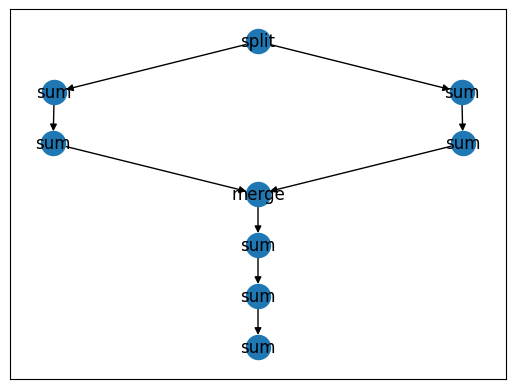

Graph of Thoughts


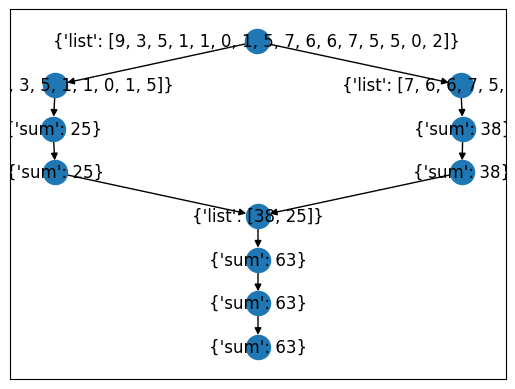

In [10]:
from pure_graph_of_thoughts.visualization import plot_graph

print('Graph of Operations')
plot_graph(env.graph_of_operations)
print('Graph of Thoughts')
plot_graph(env.graph_of_thoughts)